In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from pandas.plotting import scatter_matrix

import seaborn
from pymc3 import trace_to_dataframe

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from models import build_bayesian_linear_regression_model
from utils import get_study_metrics_data, filter_dataframe_outliers

import pandas as pd

In [2]:
#studies_to_exclude = ['neurocube_quiroga_easy2', 'synth_mearec_neuronexus_noise10_K20_C32', 'neurocube_quiroga_easy1', 'neurocube_quiroga_difficult1', 'mea_c30', 'paired_monotrode_boyden32c', 'neurocube_sim2_11K20', 'paired_monotrode_mea64c', 'paired_english', 'synth_mearec_neuronexus_noise20_K40_C32', 'neurocube_quiroga_difficult2', 'paired_crcns', 'paired_monotrode_kampff', 'synth_mearec_neuronexus_noise20_K20_C32', 'synth_mearec_neuronexus_noise20_K10_C32', 'paired_kampff', 'paired_monotrode_crcns', 'synth_mearec_neuronexus_noise10_K10_C32', 'neurocube_sim2_2K10', 'paired_boyden32c', 'paired_mea64c', 'synth_mearec_neuronexus_noise10_K40_C32']
#ALL_AVAILABLE_STUDY_SETS=['HYBRID_JANELIA', 'LONG_DRIFT', 'LONG_STATIC', 'MANUAL_FRANKLAB', 'PAIRED_BOYDEN', 'PAIRED_CRCNS_HC1', 'PAIRED_ENGLISH', 'PAIRED_KAMPFF', 'PAIRED_MEA64C_YGER', 'PAIRED_MONOTRODE', 'SYNTH_BIONET', 'SYNTH_MAGLAND', 'SYNTH_MEAREC_NEURONEXUS', 'SYNTH_MEAREC_TETRODE', 'SYNTH_MONOTRODE', 'SYNTH_VISAPY']
#STUDY_NAMES = [study_name for study_set_name in ['HYBRID_JANELIA', 'LONG_STATIC', 'SYNTH_MAGLAND', 'SYNTH_MEAREC_TETRODE'] for study_name in SFStudySet.load(study_set_name).get_study_names() if study_name not in studies_to_exclude]


STUDY_NAMES = ['hybrid_static_tetrode', 'hybrid_static_siprobe',
               'LONG_STATIC_1200s_8c', 'LONG_STATIC_600s_8c', 'LONG_STATIC_300s_16c', 'LONG_STATIC_4800s_16c',
               'LONG_STATIC_300s_8c', 'LONG_STATIC_2400s_8c', 'LONG_STATIC_2400s_16c', 'LONG_STATIC_600s_16c',
               'LONG_STATIC_1200s_16c', 'LONG_STATIC_4800s_8c', 'synth_magland_noise20_K20_C8',
               'synth_magland_noise10_K10_C4', 'synth_magland_noise10_K10_C8', 'synth_magland_noise20_K10_C4',
               'synth_magland_noise20_K20_C4', 'synth_magland_noise20_K10_C8', 'synth_magland_noise10_K20_C8',
               'synth_magland_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K10_C4',
               'synth_mearec_tetrode_noise20_K10_C4', 'synth_mearec_tetrode_noise20_K20_C4']

STATIC_SIPROBE_STUDY_NAMES = ['hybrid_static_siprobe', 'LONG_STATIC_1200s_8c', 'LONG_STATIC_600s_8c', 'LONG_STATIC_300s_16c',
                       'LONG_STATIC_4800s_16c', 'LONG_STATIC_300s_8c', 'LONG_STATIC_2400s_8c', 'LONG_STATIC_2400s_16c',
                       'LONG_STATIC_600s_16c', 'LONG_STATIC_1200s_16c', 'LONG_STATIC_4800s_8c',]

STATIC_TETRODE_STUDY_NAMES = ['hybrid_static_tetrode', 'synth_magland_noise20_K20_C8', 'synth_magland_noise10_K10_C4',
                       'synth_magland_noise10_K10_C8', 'synth_magland_noise20_K10_C4', 'synth_magland_noise20_K20_C4',
                       'synth_magland_noise20_K10_C8', 'synth_magland_noise10_K20_C8', 'synth_magland_noise10_K20_C4',
                       'synth_mearec_tetrode_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K10_C4',
                       'synth_mearec_tetrode_noise20_K10_C4', 'synth_mearec_tetrode_noise20_K20_C4']

METRIC_NAMES = [ "firing_rate", "presence_ratio", "isi_violation",
                 "amplitude_cutoff", "snr", "max_drift", "cumulative_drift",
                 "silhouette_score", "isolation_distance", "l_ratio",
                 "nn_hit_rate", "nn_miss_rate", "d_prime"]

SORTER_NAMES = ['ironclust', 'jrclust',
               'kilosort', 'kilosort2', 'klusta', 'mountainsort4',
               'spykingcircus', 'tridesclous']

# SORTER_NAMES = ['ironclust', 'jrclust',
#                 'kilosort2', 'klusta', 'mountainsort4',
#                 'spykingcircus', 'tridesclous']

RANDOM_STATE = 0
P_VALUE = 0.01

In [3]:
static_tetrode_metric_data = get_study_metrics_data(
        study_names=STATIC_TETRODE_STUDY_NAMES,
        metric_names=METRIC_NAMES,
        random_state=RANDOM_STATE,
        sorter_names=SORTER_NAMES,
        # include_meta=True,
        with_agreement_scores=True
    ).dropna(axis=0)

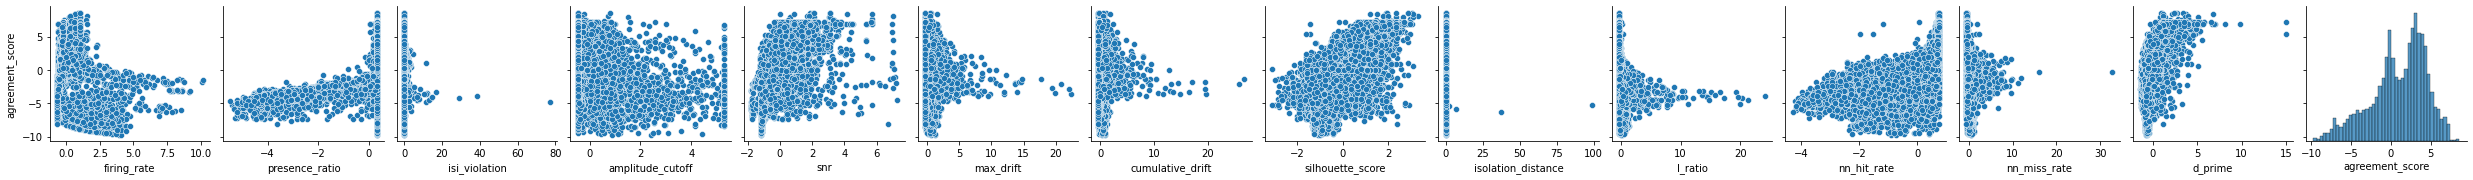

In [4]:
import seaborn as sns


tmp = static_tetrode_metric_data.copy()

standard_scalar = preprocessing.StandardScaler()
tmp[METRIC_NAMES] = standard_scalar.fit_transform(tmp[METRIC_NAMES])
# tmp['q'] = np.log(tmp['firing_rate'])

tmp['agreement_score'][tmp['agreement_score'] == 1] -= 1e-3
tmp['agreement_score'][tmp['agreement_score'] == 0] += 1e-3
tmp['agreement_score'] = np.log(tmp['agreement_score'] / (1 - tmp['agreement_score']))
sns.pairplot(tmp, y_vars=['agreement_score'])

In [5]:
# static_tetrode_metric_data['agreement_score'][static_tetrode_metric_data['agreement_score']==1.0] -= 1e-5
# static_tetrode_metric_data['agreement_score'][static_tetrode_metric_data['agreement_score']==0.0] += 1e-5

In [6]:
agreement_scores = static_tetrode_metric_data['agreement_score'].copy()
agreement_scores[agreement_scores == 1] -= 1e-3
agreement_scores[agreement_scores == 0] += 1e-3
logit_agreement_scores = np.log(agreement_scores / (1 - agreement_scores))

array([[<AxesSubplot:title={'center':'agreement_score'}>]], dtype=object)

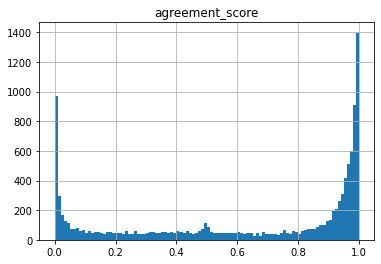

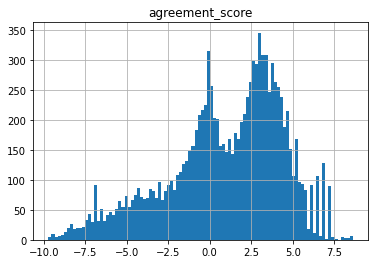

In [7]:
filter_dataframe_outliers(agreement_scores.to_frame(), n_deviations=None).hist(bins=100)
filter_dataframe_outliers(logit_agreement_scores.to_frame(), n_deviations=None).hist(bins=100)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    static_tetrode_metric_data.drop(columns=['agreement_score']),
    logit_agreement_scores,
    test_size=0.2, random_state=RANDOM_STATE)
X_train.describe()

standard_scalar = preprocessing.StandardScaler()
X_train = standard_scalar.fit_transform(X_train)
X_test = standard_scalar.transform(X_test)


In [22]:
linear_regression_model = build_bayesian_linear_regression_model(X_train, y_train, hierarchical=True)

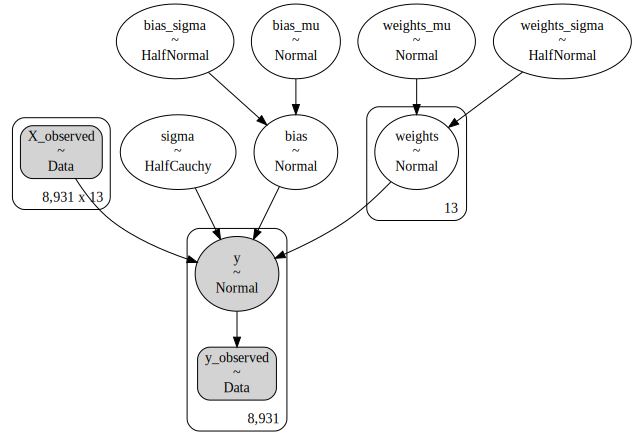

In [23]:
pm.model_to_graphviz(linear_regression_model)

In [24]:
with linear_regression_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_STATE)
    idata_prior = az.from_pymc3(prior=prior_checks)

/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/theano/tensor/basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex(data)  # works for all numeric scalars


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

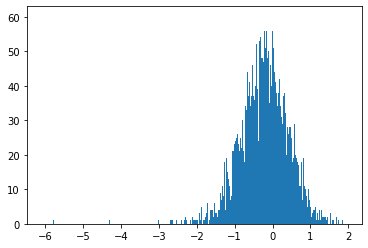

In [41]:
plt.hist(prior_checks['y'].mean(axis=0), bins=1000)


In [ ]:

_, ax = plt.subplots()
idata_prior.prior.plot.scatter(color="k", alpha=0.2, ax=ax)
ax.set_ylabel("Mean log radon level");

In [28]:
with linear_regression_model:
    pooled_trace = pm.sample(1000, target_accept=0.95, cores=4, random_seed=RANDOM_STATE, init="adapt_diag")
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2)

/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/theano/tensor/basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex(data)  # works for all numeric scalars
/tmp/ipykernel_41365/4200060446.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  pooled_trace = pm.sample(1000, target_accept=0.95, cores=4, random_seed=RANDOM_STATE, init="adapt_diag")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multipro

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
weights_mu,0.17,0.16,-0.14,0.48,0.00,0.00,3420.45,2398.31,1.00
bias_mu,0.86,0.90,-1.22,2.50,0.02,0.02,2929.37,1871.17,1.00
weights[0],-0.85,0.02,-0.89,-0.80,0.00,0.00,5238.16,3093.56,1.00
weights[1],0.96,0.03,0.90,1.01,0.00,0.00,3232.01,2975.16,1.00
weights[2],-0.14,0.02,-0.18,-0.09,0.00,0.00,4081.36,2950.95,1.00
weights[3],-0.26,0.02,-0.31,-0.22,0.00,0.00,3389.24,1925.02,1.00
weights[4],0.59,0.03,0.54,0.64,0.00,0.00,4493.42,2368.79,1.00
weights[5],-0.52,0.06,-0.63,-0.40,0.00,0.00,3146.95,2510.83,1.00
weights[6],0.37,0.06,0.25,0.48,0.00,0.00,3024.74,2572.75,1.00
weights[7],0.61,0.04,0.53,0.69,0.00,0.00,3354.16,2664.42,1.00


In [45]:
scatter_matrix(az.convert_to_inference_data(pooled_trace))

/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/theano/tensor/basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex(data)  # works for all numeric scalars


AttributeError: 'InferenceData' object has no attribute '_get_numeric_data'

In [29]:
weights = pd.Series(pooled_idata['posterior']['weights'].mean(axis=(0,1)), index=METRIC_NAMES).sort_values(key=abs)

/tmp/ipykernel_41365/2224172036.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(pooled_idata)


array([[<AxesSubplot:title={'center':'weights_mu'}>,
        <AxesSubplot:title={'center':'weights_mu'}>],
       [<AxesSubplot:title={'center':'bias_mu'}>,
        <AxesSubplot:title={'center':'bias_mu'}>],
       [<AxesSubplot:title={'center':'weights'}>,
        <AxesSubplot:title={'center':'weights'}>],
       [<AxesSubplot:title={'center':'bias'}>,
        <AxesSubplot:title={'center':'bias'}>],
       [<AxesSubplot:title={'center':'weights_sigma'}>,
        <AxesSubplot:title={'center':'weights_sigma'}>],
       [<AxesSubplot:title={'center':'bias_sigma'}>,
        <AxesSubplot:title={'center':'bias_sigma'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

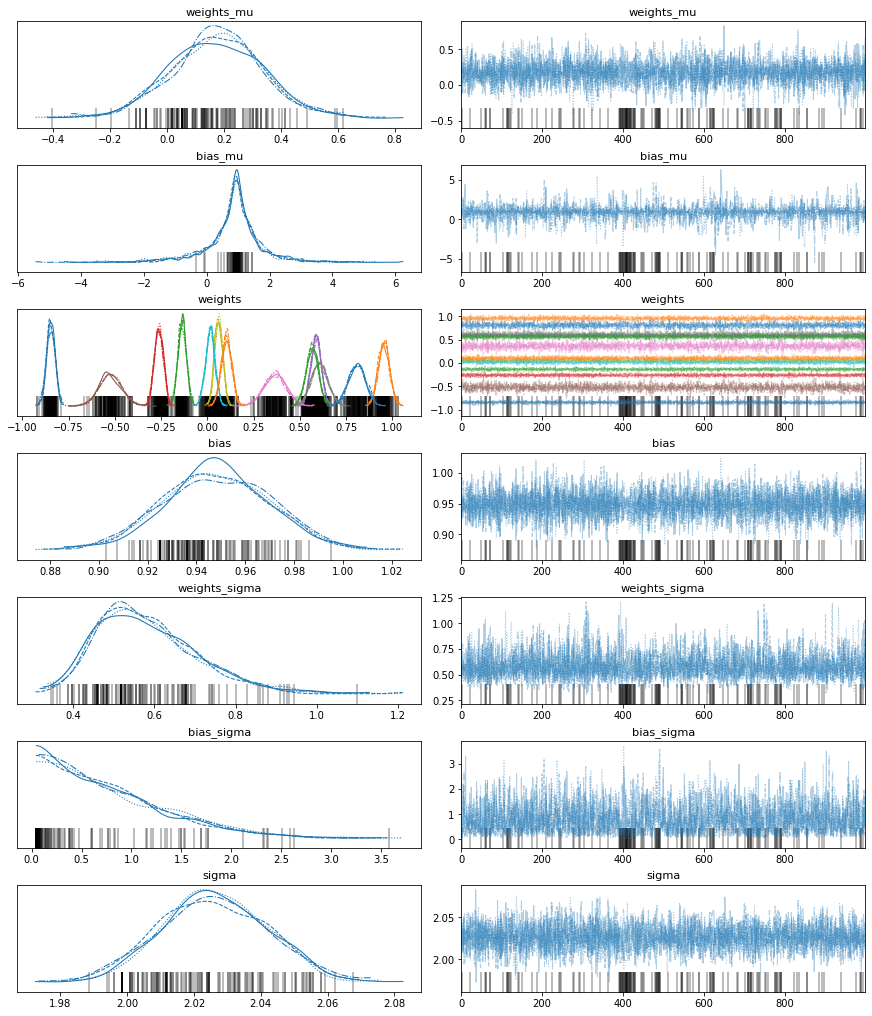

In [30]:
pm.traceplot(pooled_idata)

In [27]:
for metric_name_A in METRIC_NAMES:
    for metric_name_B in METRIC_NAMES:
        plt.figure(figsize=(9, 7))
        seaborn.jointplot(pooled_trace[metric_name_A], pooled_trace[metric_name_B], kind="hex", color="#4CB391")
        plt.xlabel(metric_name_A)
        plt.ylabel(metric_name_B)

KeyError: 'firing_rate'

<Figure size 648x504 with 0 Axes>

In [31]:
with linear_regression_model:

    # change the value and shape of the data
    pm.set_data(
        {
            "X_observed": X_test,
            # use dummy values with the same shape:
            "y_observed": y_test,
        }
    )

    post_pred = pm.sample_posterior_predictive(pooled_trace)

/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/theano/tensor/basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex(data)  # works for all numeric scalars


In [32]:
y_preds = [sample_pred.mean() for sample_pred in (1/(np.exp(-post_pred['y']) + 1)).T]

In [35]:
from sklearn.metrics import mean_squared_error

zeros = np.ones(shape=y_test.shape[0])
baseline_rmse = np.sqrt(mean_squared_error((1/(np.exp(-y_test) + 1)), zeros))

In [36]:
rmse = np.sqrt(mean_squared_error((1/(np.exp(-y_test) + 1)), y_preds))